In [21]:
import datetime
import scipy as scp
import scipy.signal
import numpy as np
import sklearn.metrics 
import pickle

import warnings

import h5py

In [23]:
from ribbonv2 import *
from samplingv4 import *
from plotResult_v2 import *

In [6]:
"""
load data
"""

filename = '../data/cell1.hdf5'
f = h5py.File(filename, 'r')

for item in f.attrs:
    print(item, f.attrs[item])
    
stim_binary = f['stim_binary'][:]
#stim_gauss = f['stim_gauss'][:]

r_binary = f['r_binary'][:]
#r_gauss = f['r_gauss'][:]

f.close()


"""
for second cell 
"""
filename = '../data/cell2.hdf5'
f = h5py.File(filename, 'r')

for item in f.attrs:
    print(item, f.attrs[item])
    
#stim_binary = f['stim_binary'][:]
#stim_gauss = f['stim_gauss'][:]

#r_binary = f['r_binary'][:]
#r_gauss = f['r_gauss'][:]

f.close()




# choose data
light = stim_binary
data = r_binary

# stim time with time resolution of dt =1ms
stimT = np.arange(0, len(light),1)/1000


dt[ms] for r = 10
dt[ms] for stim = 1
info: Stim and vesicle release of one cell, 4 recordings per stim, binned sum for r but raw for stim (dt=1)
dt[ms] for r = 10
dt[ms] for stim = 1
info: Stim and vesicle release of one cell, 2 recordings per stim, binned sum for r but raw for stim (dt=1)


In [11]:
"""
pickle opening the fitting results:
"""

# BINARY 1st cell:
filename = 'fitting_results/save_data_v6_3.pkl'

# BINARY 2nd cell:
#filename = 'save_data_binary_cell2_v6_0.pkl'

# GAUSS 1st cell
#filename = 'save_data_gauss_v6_0.pkl'

with open(filename, "rb") as f:
    dict_load = pickle.load(f)
    
hypersSave = dict_load['hypers']
outRSave = dict_load['samples']
metaInfo = dict_load['metaInfo']



#trueK,trueX0,trueDockP,trueRibbonLambda ,dockMax,ribbonMax,truerho ,truescale= trueparams

In [12]:
metaInfo

'batchsize: 4, nSamps0: 40000, nSampsLate: 20000, nupdate0: 10, nupdate_late: 10, w_scale: [5. 5. 5. 5. 2. 2. 4. 2. 1.], runs: 100            '

In [15]:
"""
load GLM predictions
"""

with open("baseline_model/glm_predictions.pkl", "rb") as f:
    glm_data = pickle.load(f)

glm_fit = glm_data['glm_predictions']

### produce data summary stats

In [24]:
"""
specify summary stats

for n>1
"""

#data=data[1:]

nSS = 9


## specify kernel to compare traces
g = scipy.signal.gaussian(10,2)

  




# number of recorded traces
nTrue = len(data)

lenData = len(data[0])
trueG = np.zeros((nTrue,lenData+len(g)-1))

for i in range(nTrue):
    trueG[i,:] = scipy.signal.convolve(data[i],g)
  

# specify weights for summary stats
w_scale = [5., 5., 5., 5., 2., 2., 4., 2., 1.]
unweighted_data_SS = makeSS(data,g,trueG, w = np.ones(nSS))
# normalizing factor
w_norm = 1/unweighted_data_SS
w_norm[np.isinf(w_norm)] = 1/48 #(1/48 mean value for the recorded traces)


# final w 
w = w_norm * w_scale

dataSS = makeSS(data,g,trueG,w)


    
    
    
 

In [26]:
makeSS(data, g, trueG,w)

array([5., 5., 5., 5., 2., 2., 4., 2., 1.])

In [27]:
   
dataSS_single= np.zeros((nTrue,nSS))

for i in range(0,nTrue):
    trueG[i] = scipy.signal.convolve(data[i],g)
    dataSS_single[i] = makeSS(data[i],g,trueG[i], w)

meanSS = np.mean(dataSS, axis = 0)


In [30]:
"""
specify priors here!!!
also: dock and ribbon size
"""

dockMax = 7
ribbonMax = 50

def makeHypersPrior():
    """
    :return: hyper parameters for the ribbon prior distributions
    """
    k_x0Hypers = [np.array([10, 0.5]), np.eye(2) * np.array([400, 0.1]), 4, 4]  # [mu0s,Lambda0, kappa0, nu0]
    dPHypers = [0.3, 0.05, 3, 3]  # [mu0, sigma0sq, kappa0, nu0]
    rlHypers = [2, 0.25]  # [k, scale(theta)] # mean=k*theta
    rhoHypers = [0.5, 0.05, 3, 3]  # [mu0, sigma0sq, kappa0, nu0]
    
    kernelscaleHypers = [1.5, 0.1, 3, 3]  # [mu0, sigma0sq, kappa0, nu0]

    
    hypers = [k_x0Hypers, dPHypers, rlHypers, rhoHypers, kernelscaleHypers]
    return hypers



# specify stimulus

def run_parallel_ribbon(*parameters):
    sampsParams = np.array(parameters)
    outUn =  runManyRibbon(light, g,trueG,dataSS, sampsParams, batchsize, w, stim_kind='light')
    return outUn


#### Plot mean and exp values

In [31]:
def plot_1d_marginals(hypers,
                      label=None,
                      limits=[[0, 50], [0, 2], [0, 1], [0, 1], [0, 1],[0,2]],
                      param_labels=['K', 'X0', 'DockP', 'RibbonLambda', 'rho', 'kernelscale'],
                      plot_true=False,
                      truevalues=None,
                      figsize=(12, 6)):
    """
    :param hypers: hyperparameter of one round
    :param label:
    :param limits:
    :param param_labels:
    :param plot_true:
    :param truevalues:
    :param figsize:
    :return:
    """
    mus_normal = np.zeros(6)
    mus_normal[0] = hypers[0][0][0]
    mus_normal[1] = hypers[0][0][1]
    mus_normal[2] = hypers[1][0]
    mus_normal[3] = -1  # no normal distribution
    mus_normal[4] = hypers[3][0]
    mus_normal[5] = hypers[4][0]

    stds_normal = np.zeros(6)
    stds_normal[0] = (1 / (hypers[0][3] - 3) * hypers[0][1][0, 0] ) ** 0.5  # [muns,Lambdan, kappan, nun]
    stds_normal[1] = (1 / (hypers[0][3] - 3) * hypers[0][1][1, 1] ) ** 0.5  # [muns,Lambdan, kappan, nun]
    stds_normal[2] = (hypers[1][3] / (hypers[1][3] - 2) * hypers[1][1] ) ** 0.5  # [mun, sigman^2, kappan, nun]
    stds_normal[3] = -1  # no normal distribution
    stds_normal[4] = (hypers[3][3] / (hypers[3][3] - 2) * hypers[3][1] ) ** 0.5  # [mun, sigman^2, kappan, nun]
    stds_normal[5] = (hypers[4][3] / (hypers[4][3] - 2) * hypers[4][1] ) ** 0.5  # [mun, sigman^2, kappan, nun]

    # for ribbon lambda, gamma distribution
    kLambda = hypers[2][0]
    thetaLambda = hypers[2][1]

    plt.figure(1, figsize=figsize)
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.title(param_labels[i])
        x = np.arange(limits[i][0], limits[i][1], 0.001)
        if not (i == 3):
            y = scp.stats.norm.pdf(x, mus_normal[i], stds_normal[i])
        else:
            y = scp.stats.gamma.pdf(x, kLambda, scale=thetaLambda)

        plt.plot(x, y, label=label)
        if plot_true:
            plt.axvline(truevalues[i], color='r', alpha=0.5)
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


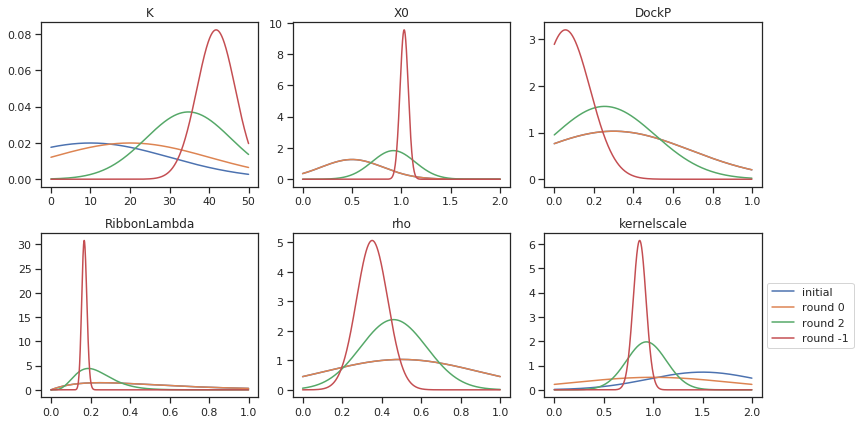

In [32]:
#truevalues = [trueK, trueX0, trueDockP, trueRibbonLambda, truerho, truescale]
hypers_prior = makeHypersPrior()

limits = [[0, 50], [0, 2], [0, 1], [0, 1], [0, 1], [0,2]]
plot_1d_marginals(hypers_prior, label='initial', limits=limits)
plot_1d_marginals(hypersSave[0], label='round 0', plot_true=False, limits=limits, truevalues=None)
plot_1d_marginals(hypersSave[2], label='round 2', limits=limits)
plot_1d_marginals(hypersSave[-1], label='round -1', limits=limits)

### plotting time course

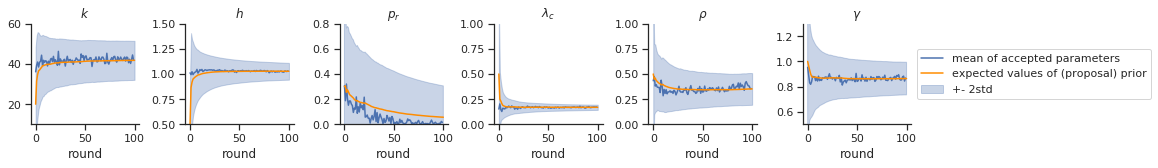

In [33]:

def plot_time_course_flat(outRSave, exp_values, nbest=100, plotTrue=False, trueParams=None, plotStds=False, stds=None,
                     ylimits=[None]*6,
                     param_labels=['$k$', '$h$', '$p_r$', '$\\lambda_c$', '$\\rho$', '$\\gamma$']):
    runs = np.shape(outRSave)[0]
    sns.set_style('ticks')

    # calculate mean of best params per run (still includes the fixed params)
    means_raw = np.zeros((runs, 9))
    for i in range(runs):
        means_raw[i] = np.mean(outRSave[i][:, :nbest], axis=1)

    means = np.zeros((runs, 6))
    means[:, :4] = means_raw[:, :4]
    means[:, 4] = means_raw[:, 6]
    means[:, 5] = means_raw[:, 7]


    #plt.figure(1, figsize=(12, 12))
    #plt.suptitle('Time course of the expected values of (proposal) prior', y=1.01)
    i=0
    for i in range(0,6): #[9,17,25,33,41,49]: # diagonal: [1,8,15,22,29,36]:
        plt.subplot(1, 6, i+1)
        
        plt.title(param_labels[i])
        plt.plot(means[:, i], label='mean of accepted parameters')
        plt.plot(exp_values[:, i], label='expected values of (proposal) prior', color='darkorange')
        if plotTrue:
            plt.axhline(trueParams[i], color='r', alpha=1, label='true value')
        if plotStds:
            plt.fill_between(np.arange(len(exp_values)),exp_values[:,i]-2*stds[:,i],
                             exp_values[:,i]+2*stds[:,i],
                             alpha=0.3,
                             color='b', label='+- 2std')
        plt.ylim(ylimits[i])

        plt.xticks([0,50,100])
        plt.xlabel('round')
        sns.despine()
        i +=1
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# get values to plot
exp_values = get_expected_values_all(hypersSave[1:], hypersSave[0])
stds = get_stds_all(hypersSave[1:], hypersSave[0])

#trueParams = [trueK, trueX0, trueDockP, trueRibbonLambda,truerho, truescale ]


bounds = [[10,60],[0.5,1.5],[0,0.8],[0,1],[0,1],[0.5,1.3]]

sns.set_context('notebook')

plt.figure(1, figsize=(13,2.5))
plot_time_course_flat(outRSave, exp_values, plotTrue=False, trueParams=None, plotStds=True, stds=stds, nbest=10,
                ylimits=bounds)
                # ylimits=[[10,30],[0.7,0.9],[0.2,0.9],[0.15,0.25],[0.2,0.6]])
        
        
        
filename = 'timecours_bindata_flat_v1_1.svg'
#plt.savefig(filename, bbox_inches='tight', format='svg')



## plot 2 d marginals

In [34]:
# how to use these plotting fcts
hypers_prior = makeHypersPrior()
hypers = hypersSave[-1]

posteriors = make_posteriorlist(hypers)
priors = make_posteriorlist(hypers_prior)

# use same bounds and tpts if uses in one plot
# this might take long!!!
bounds = [[10,50],[0.5,1.5],[0,0.5],[0,1],[0,1],[0.5,1.3]]
tpts = 20
marginal2D_df, ts = evaluate_2D_marginals(posteriors, bounds, tpts)
marginal2D_df_prior, ts = evaluate_2D_marginals(priors, bounds, tpts)

points = extract_points(outRSave[-1], 100)




In [35]:
def plot_2d_marginals(marginal2D_df, ts,
                      label1d='posterior',
                      plot_points=False, points=None,
                      plot_prior=False, marginal2D_df_prior=None,
                      cmap='magma', color='blue',
                      plotcontours=False, contours=None, contourcolors=['yellow', 'orange'],
                      # contours not yet implemented
                      plot2dprior=False, priorcontours=None, priorcontouralpha=0.2,
                      plot_true=False, truepoint=None,
                      plot_hist=False):
    """
    plots all 2d marginals
    ---
    :param marginal2D_df: pandas df, output[0] of evaluate_2D_marginals
    :param t_marginal: output[1] of evaluate_2D_marginals
    :param boundsnorm: normalization bounds to scale 1d marginals
    :param plotpoints: boolean, if True: plot points into 2D marginals
    :param points: list, list of points to plot
    :return:
    """
    # set seaborn
    #sns.set_context("notebook")
    #sns.set_style("white")

    labels = param_labels=['$k$', '$h$', '$p_r$', '$\\lambda_c$', '$\\rho$', '$\\gamma$']
    #['K', 'X0', 'DockP', 'RibbonLambda', 'rho', 'kernelscale']

    # plotting
    fig = plt.figure(1, figsize=(12, 12))
    count = 0

    for i in range(6):
        for j in range(6):
            count += 1

            if i < j:
                plt.subplot(6, 6, count)

                ax = sns.heatmap(marginal2D_df[i][j][::-1],
                                 xticklabels=[],
                                 yticklabels=[],
                                 square=True, cbar=False,
                                 linewidths=0, linecolor='black',
                                 rasterized=True,
                                 cmap=cmap,
                                 )
                plt.ylabel('')
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)

                if plot_points:
                    for nrpoint in range(len(points)):
                        # plotting single points
                        singlepoint = points[nrpoint]
                        # print(singlepoint[i],singlepoint[j])

                        # normalize to the size of datafram (st all values are between [0,1] * size(df))
                        xi_scaled = (singlepoint[i] - ts[i][0]) / (ts[i][-1] - ts[i][0]) * len(ts[i])

                        xj_scaled = (singlepoint[j] - ts[j][0]) / (ts[j][-1] - ts[j][0]) * len(ts[j])
                        plt.plot(xj_scaled, len(ts[i]) - xi_scaled, 'o', color=color, alpha=0.5)

                        # plt.axvline(xj_scaled)
                        # plt.axhline(xi_scaled)
                if plot_true:
                    # plotting single points
                    singlepoint = truepoint

                    # normalize to the size of datafram (st all values are between [0,1] * size(df))
                    xi_scaled = (singlepoint[i] - ts[i][0]) / (ts[i][-1] - ts[i][0]) * len(ts[i])

                    xj_scaled = (singlepoint[j] - ts[j][0]) / (ts[j][-1] - ts[j][0]) * len(ts[j])
                    plt.plot(xj_scaled, len(ts[i]) - xi_scaled, 'o', color='r', alpha=1)

                    # plt.axvline(xj_scaled)
                    # plt.axhline(xi_scaled)
                if plotcontours:
                    plt.contour(contours[i, j], colors=contourcolors, alpha=0.9)

                if plot2dprior:
                    plt.contour(priorcontours, colors=['orange', 'orange'], alpha=priorcontouralpha)


            elif i == j:
                ax = plt.subplot(6, 6, count)
                plt.title(labels[i])

                # plot 1d marginals
                current_color = 'b'#sns.color_palette()[1]
                plt.plot(ts[i], marginal2D_df[i][i],
                         color=current_color,
                         label=label1d)

                if plot_prior:
                    # plot one 1D prior
                    plt.plot(ts[i], marginal2D_df_prior[i][i], label='prior', color='darkorange')

                if plot_true:
                    plt.axvline(truepoint[i], color='r', label='true value')

                if plot_hist:
                    sns.distplot(points[:, i], kde=True)

                plt.xlim(ts[i][0], ts[i][-1])
                ax.spines['left'].set_visible(True)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(True)  # plot legend in last case
                if i == 5:
                    plt.legend(loc='center left', bbox_to_anchor=(-2, 0.5))

                # remove y ticks
                plt.yticks([])

    # plt.tight_layout()

    #fig.subplots_adjust(top=0.95)
    # fig.suptitle('This is an amazing title')

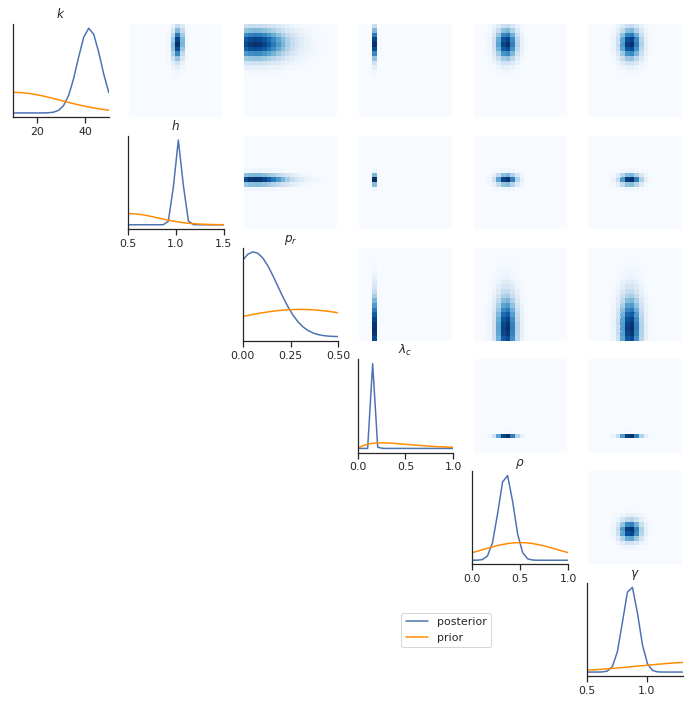

In [36]:

#plt.figure(1, figsize=(12,12))
plot_2d_marginals(marginal2D_df,
                  ts, cmap = 'Blues',
                 plot_prior=True, marginal2D_df_prior=marginal2D_df_prior,
                  plot_points = False, points=points, plot_hist=False,
                 plot_true=False, truepoint=None)



filename = 'posterior2d_data_binary.svg'
#plt.savefig(filename, bbox_inches='tight', format='svg')




### plot NL

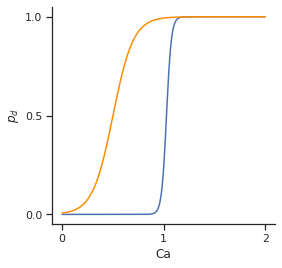

In [37]:
def plotsigmoidscomparison(kvector, x0vector, plot_label=False, labels=None, colors=[None]*10):
    """
    plots two sigmoids (k[0],x0[0]), and (k[1],x0[1])
    """
    t = np.arange(0, 2, 0.001)

    x = np.zeros((len(kvector), len(t)))
    for i in range(len(kvector)):
        x[i] = sigmoid(t, kvector[i], x0vector[i])

    #plt.figure(1, figsize=(8, 6))

    if plot_label:
        for i in range(len(kvector)):
            plt.plot(t, x[i,], label=labels[i] + ': x0=%.1f, k=%i ' % (x0vector[i], kvector[i]), color=colors[i])

    else:
        for i in range(len(kvector)):
            plt.plot(t, x[i,], label='x0=%.1f, k=%i ' % (x0vector[i], kvector[i]), color=colors[i])

    #plt.title('Sigmoid of Ca release dependency')
    plt.xlabel('Ca')
    plt.ylabel('$p_d$')
    #plt.legend()
    sns.despine()
    plt.xticks([0,1,2])
    plt.yticks([0,0.5,1])

# how to use it


kfit, x0fit, _,_,_,_ = get_expected_values(hypersSave[-1])
kprior, x0prior, _,_,_,_ = get_expected_values(makeHypersPrior())


plt.figure(1, figsize=(4,4))
plotsigmoidscomparison([kfit, kprior],[x0fit, x0prior], 
                       plot_label=True, 
                       labels=[ 'fit', 'prior'],
                      colors=['b', 'darkorange', 'r'])


### plot kernel

In [40]:
"""
NeurIPS version
"""
sns.set_style('ticks')

def plot_kernel(scales, labels, colors=[None]*10):
    for i, scale in enumerate(scales):
        celltype=-1
        light_ca_kernel =  - celltype * cone_kernel_scale(scale)
        plt.plot(light_ca_kernel, label=labels[i], color=colors[i])
        plt.legend()
        plt.xlabel('ms')
        sns.despine()
        #plt.title('light-Ca-kernel')
        plt.xticks([0,100,200,300])
        plt.yticks([0])
        plt.ylabel('linear filter')
        
        



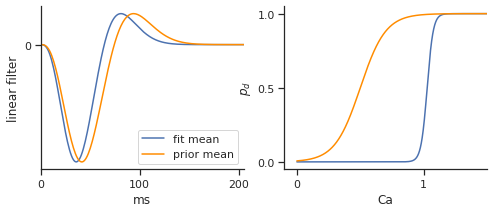

In [41]:
"""
both for NIPS
"""
_, _, _,_,_,scale_fit = get_expected_values(hypersSave[-1])
_, _, _,_,_,scale_prior = get_expected_values(hypersSave[0])



plt.figure(1, figsize=(8,3))

plt.subplot(121)
plot_kernel([ scale_fit, scale_prior ], labels=[ 'fit mean', 'prior mean', 'true'], colors=['b', 'darkorange','r'])

plt.xlim(-0.1,205)

plt.subplot(122)
plotsigmoidscomparison([kfit, kprior],[x0fit, x0prior], 
                       plot_label=False, 
                       labels=[ 'Fit', 'prior', 'true'],
                      colors=['b', 'darkorange', 'r'])

plt.xlim(-0.1,1.5)

filename = 'kernel_NL_bindata.svg'
plt.savefig(filename, bbox_inches='tight', format='svg')

## run simulations

In [42]:
def runOne_with_kernel(params_all, light):
    params = params_all[:-1]
    kernel_scale = params_all[-1]
    # compute stimulus
    # convolve to get Ca trace
    light_ca_kernel =  - celltype * cone_kernel_scale(kernel_scale)
    stimCon = scp.signal.convolve(light, light_ca_kernel, mode="full")[:len(light)]  # /(1/dtstim *10)
    # resample and normalize
    dtstim = 0.001 # in ms
    Ca_raw = resampleCon(stimCon, dtstim)
    # normalize stim
    stim = (Ca_raw - np.min(Ca_raw)) / np.max(np.abs(Ca_raw - np.min(Ca_raw)))

    # run number of simulations according to the batchsize
    rel1 = runOne( params, stim, correlated=True)
    return rel1

In [43]:
"""
Run multiple simulations with the fitted values
# choose therefor paramsfit
"""


dockMax = 7
ribbonMax = 50

#np.random.seed(13) 
np.random.seed(13) 
 

celltype=-1
nfit = 10#10

paramsmean =outRSave[-1,:-1,:20].mean(axis=1)
paramsfit_raw = get_expected_values(hypersSave[-1])

params_test =  [12.9, 1.21, 0.56, 0.47, 8, 50, 0.4 ]
#[16,1.2,0.45,0.5,8,50,0.38]
#np.array([2.92130595e+01, 6.14609107e-01, 4.08833161e-04, 1.90132667e-01,
#       8.00000000e+00, 5.00000000e+01, 1.77871633e-01, 2.12069024e+01])
#[47.7662607,   1.21467967 , 0.64055392,  0.46229319,  8., 50., 0.40482185]



# add the maximal dock/ribbon in fitted params
paramsfit = np.zeros(8)
paramsfit[:4] = paramsfit_raw[:4]
paramsfit[4:6] = np.array([dockMax,ribbonMax ])
paramsfit[6] = paramsfit_raw[4]
paramsfit[7] = paramsfit_raw[5]


fit = np.zeros((nfit,len(data[0])))
fitG = np.zeros(np.shape(trueG))

# good values!!!: 
params_test = [42, 1.01, 0.0013, 0.25, 8,50, 0.5]

for i in range(nfit):
    fit[i] = runOne_with_kernel(paramsmean, light) #paramsmean
    #fitG[i,:] = scipy.signal.convolve(fit[i],g)

### compare summary stats

In [45]:
def Calc_VarSS_fit(traces, dataSS, trueG,g,w, mode='fitted'):
    """
    calculates the mean and var of the summary stats of traces to the meanSS
    """
    meandataSS = dataSS#np.mean(dataSS, axis=0)
    #meandataSS[0] = 1
    
    fitSS = np.zeros((len(traces), len(trueG), 9))

    for i in range(len(traces)):
        for j in range(len(trueG)):
            fitSS[i, j] = makeSS(traces[i], g, trueG[j],w)

    fitSS1 = np.mean(fitSS, axis=1)
    #fitSS1[0] = 0

    # print(fitSS1)
    dists = np.zeros(len(fitSS1))
    for i in range(len(fitSS1)):
        dists[i] = scipy.spatial.distance.euclidean(fitSS1[i], meandataSS)

    meanDist = np.mean(dists)
    varDist = np.var(dists)

    return meanDist, varDist, dists

In [46]:
dataSS =  makeSS(data, g, trueG,w)

In [51]:
Calc_VarSS_fit(fit, dataSS, trueG,g,w )

(6.584746363993202,
 0.09620360939698434,
 array([6.25334584, 6.41784526, 6.07504313, 6.45776917, 7.17051114,
        6.78317185, 6.53961267, 6.46178384, 6.92833588, 6.76004487]))

In [52]:
Calc_VarSS_fit(data,dataSS, trueG,g,w )

(2.666755490817579,
 0.6919231522917746,
 array([3.45571293, 3.46680665, 2.22059209, 1.5239103 ]))

In [54]:

def plot_event_histo(data,  sumstatnames = ['1-q','2-q','3-q','4-q','5-q','6-q','7-q' ],
                     color='b',
                    alpha=1,
                    errcolor='black',
                    label=None):
    """
    :param data: array (ntraces, release)
    :param figsize:
    :param sumstatnames:
    :param color:
    :param alpha:
    :param errcolor:
    :return:
    """

    dn = np.zeros((len(data),7))
    for i in range(len(data)):
        #dn[i,0]= np.sum(data[i])
        for j in range(0,7):
            dn[i,j]= np.sum(data[i]==j+1)

    df = pd.DataFrame(dn)

    df.columns = sumstatnames


    #sns.set_context("notebook")
    #sns.set_style("white")


    #plt.figure(1, figsize=(10,6))
    ax = sns.barplot( data=df,  ci='sd',capsize=.2, errwidth=2, estimator=np.mean,
                     color=color,
                     alpha=alpha,
                     errcolor=errcolor,
                    label=label)
    plt.xlabel('event type')
    plt.ylabel('count')
    plt.legend()
    sns.despine()


def plot_pairwise_loss_comparison(data, fit,w, colordata='r', colorfit='b', alpha=0.5):
    g = scp.signal.gaussian(10, 2)

    fitloss = pairwise_loss(data, g, w, mode='fit', fit=fit)
    dataloss = pairwise_loss(data, g, w, mode='data')

    # data
    df = pd.DataFrame(dataloss)
    df.columns = [None]
    ax = sns.barplot(data=df, ci='sd', capsize=.2, errwidth=2, estimator=np.mean,
                     color=colordata,
                     alpha=alpha,
                     errcolor='r',
                     label='data')

    # fit
    df = pd.DataFrame(fitloss)
    df.columns = [None]
    ax = sns.barplot(data=df, ci='sd', capsize=.2, errwidth=2, estimator=np.mean,
                     color=colorfit,
                     alpha=alpha,
                     errcolor='b',
                     label='fit')

    sns.despine()
    plt.xlabel('discrepancy')


def plot_event_loss_histo_comprison(data, fit,w, alpha=0.5, label='data', color='r', errcolor='r'):
    plt.figure(1, figsize=(6, 3))

    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
    ax0 = plt.subplot(gs[0])
    # plt.subplot(121)
    plot_event_histo(data, alpha=0.5, label='data', color='r', errcolor='r')
    plot_event_histo(fit, alpha=0.5, label='fit', color='b', errcolor='b')
    ax1 = plt.subplot(gs[1])
    plot_pairwise_loss_comparison(data, fit,w)

# plot_event_loss_histo_comprison(data,fit)

"""
new version: "pairwise loss"
rest vs 1


TAKE THIS AS BEST APPROXIMATION TO MEAN
"""


def pairwise_loss(data, g, w, mode, fit=None):
    """
    calculates the all-1 vs one
    if mode=data: between data traces ( mean of all-1 vs one)
    if mode=fit: between data and fit (mean data vs one fit)
    """
    w = np.copy(w)
    #w[0] = 0.062
    w[-1] = 0
    nsumstats = 9
    if mode == 'data':
        fitSS = np.zeros((len(data), nsumstats))
        dists = np.zeros(len(data))
        trueG = np.zeros((len(data) - 1, len(data[0]) + len(g) - 1))

        for i in range(len(data)):
            a = list(range(len(data)))
            a.pop(i)

            count = 0
            for j in a:  # all data except one (i-th)
                trueG[count] = scipy.signal.convolve(data[j], g)
                count += 1
            dataSS = makeSS(data[np.arange(len(data)) != i], g, trueG, w)
            # print(dataSS)
            fitSS[i] = makeSS(data[i], g, trueG, w)
            # print(fitSS[i])
            # print()
            dists[i] = scipy.spatial.distance.euclidean(fitSS[i], dataSS)



    elif mode == 'fit':
        fitSS = np.zeros((len(fit), nsumstats))
        dists = np.zeros(len(fit))
        trueG = np.zeros((len(data), len(data[0]) + len(g) - 1))

        for i in range(len(data)):
            trueG[i, :] = scipy.signal.convolve(data[i], g)
        for i in range(len(fit)):
            # trueG = scipy.signal.convolve(data,g)
            dataSS = makeSS(data, g, trueG, w)
            #print(dataSS)
           # print(w)
            fitSS[i] = makeSS(fit[i], g, trueG, w)  # take all fitted traces
            # print(fitSS[i])
            # print()
            dists[i] = scipy.spatial.distance.euclidean(fitSS[i], dataSS)

    else:
        print('this mode is not yet implemented. choose fit or data.')

    return dists




In [55]:
fitloss = pairwise_loss(data, g, w, mode='fit', fit=fit)
dataloss = pairwise_loss(data, g, w, mode='data')

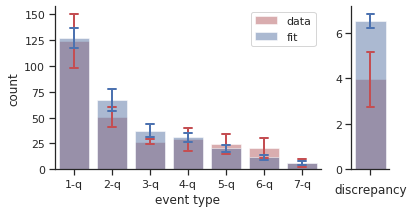

In [56]:
w_scale_one = np.ones(9)

sns.set_style('ticks')

w = w_norm * w_scale


plot_event_loss_histo_comprison(data,fit, w)

##filename = 'histo_data_bin.svg'
#plt.savefig(filepath+filename, bbox_inches='tight', format='svg')

##### newer version, relative frequency

In [57]:

def plot_pairwise_loss_comparison_new(data, fit,w, 
                                  plot_glm=False,
                                   glm_data=None,
                                 dodge=0.3):
    """
    single plot of loss as pointplot
    """
    
    g = scp.signal.gaussian(10, 2)

    fitloss = pairwise_loss(data, g, w, mode='fit', fit=fit)
    dataloss = pairwise_loss(data, g, w, mode='data')
    if plot_glm:
        glmloss = pairwise_loss(data, g, w, mode='fit', fit=glm_data)
        
    # create df
    
    df = pd.DataFrame(dataloss)
    df.columns=['loss']
    df['datatype'] = pd.Series('data', index=df.index)
    
    df1 = pd.DataFrame(fitloss)
    df1.columns=['loss']
    df1['datatype'] = pd.Series('LNR-model', index=df1.index)
    df = df.append(df1,ignore_index=True )
    
    if plot_glm:
        df1 = pd.DataFrame(glmloss)
        df1.columns=['loss']
        df1['datatype'] = pd.Series('GLM', index=df1.index)
        df = df.append(df1,ignore_index=True )

    df['dummy'] = pd.Series('', index=df.index)
            
    #print(df)
    ax = sns.pointplot( data=df,
                        x = 'dummy',
                        y='loss',  
                        hue='datatype',
                        kind='point',
                        ci='sd',
                        capsize=0,  # .2 
                        errwidth=2, 
                        estimator=np.mean,
                        palette=['r','b','g'],
                        markers=[".", ".",'.'],
                        join=False,
                        dodge=dodge)
    plt.ylim(0)
    sns.despine()
    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(leg_handles, [], title='')
    
    plt.xlabel('discrepancy')


def plot_event_loss_histo_comprison_relative(data, fit,w, 
                                             label='data', 
                                             plot_glm=False,
                                            glm_data=None,
                                            dodge=0.3,
                                            relative=True):
    """
    final plot combining histograms and loss
    """
    
    plt.figure(1, figsize=(6, 3)) # 6,3

    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
    ax0 = plt.subplot(gs[0])
    # plt.subplot(121)
    plot_event_histo_relative(data, fit, plot_glm=plot_glm, glm_data=glm_data, dodge=dodge, relative=relative)
   
    ax1 = plt.subplot(gs[1])
    plot_pairwise_loss_comparison_new(data, fit,w, glm_data=glm_data, plot_glm=plot_glm, dodge=dodge)


"""
new version: "pairwise loss"
rest vs 1


TAKE THIS AS BEST APPROXIMATION TO MEAN
"""


def pairwise_loss(data, g, w, mode, fit=None):
    """
    calculates the all-1 vs one
    if mode=data: between data traces ( mean of all-1 vs one)
    if mode=fit: between data and fit (mean data vs one fit)
    """
    w = np.copy(w)
    #w[0] = 0.062
    w[-1] = 0
    nsumstats = 9
    if mode == 'data':
        fitSS = np.zeros((len(data), nsumstats))
        dists = np.zeros(len(data))
        trueG = np.zeros((len(data) - 1, len(data[0]) + len(g) - 1))

        for i in range(len(data)):
            a = list(range(len(data)))
            a.pop(i)

            count = 0
            for j in a:  # all data except one (i-th)
                trueG[count] = scipy.signal.convolve(data[j], g)
                count += 1
            dataSS = makeSS(data[np.arange(len(data)) != i], g, trueG, w)
            # print(dataSS)
            fitSS[i] = makeSS(data[i], g, trueG, w)
            # print(fitSS[i])
            # print()
            dists[i] = scipy.spatial.distance.euclidean(fitSS[i], dataSS)



    elif mode == 'fit':
        fitSS = np.zeros((len(fit), nsumstats))
        dists = np.zeros(len(fit))
        trueG = np.zeros((len(data), len(data[0]) + len(g) - 1))

        for i in range(len(data)):
            trueG[i, :] = scipy.signal.convolve(data[i], g)
        for i in range(len(fit)):
            # trueG = scipy.signal.convolve(data,g)
            dataSS = makeSS(data, g, trueG, w)
            #print(dataSS)
           # print(w)
            fitSS[i] = makeSS(fit[i], g, trueG, w)  # take all fitted traces
            # print(fitSS[i])
            # print()
            dists[i] = scipy.spatial.distance.euclidean(fitSS[i], dataSS)

    else:
        print('this mode is not yet implemented. choose fit or data.')

    return dists


def create_data_histo(data_orig, fit, 
                    sumstatnames = ['1-q','2-q','3-q','4-q','5-q','6-q','7-q' ],
                    plot_glm=False, glm_data=None,
                    relative=True):
    """
    creates datafram for dat, fit and glmdata
    """
       
    # for data
    data = data_orig
    dn = np.zeros((len(data),7))
    for i in range(len(data)):
        #dn[i,0]= np.sum(data[i])
        for j in range(0,7):
            dn[i,j]= np.sum(data[i]==j+1)
    
    if relative:
        total_events_per_sim = np.sum(dn, axis=1)
    else:
        total_events_per_sim = np.ones(len(data))
        
    i=0
    df = pd.DataFrame((dn[i].T/total_events_per_sim[i]))
     #df1.columns = sumstatnames
    df['datatype'] = pd.Series('data', index=df.index)
    df['eventtype'] = pd.Series(sumstatnames, index=df.index)
    
    for i in range(1,len(data)):
        df1 = pd.DataFrame((dn[i].T/total_events_per_sim[i]))
         #df1.columns = sumstatnames
        df1['datatype'] = pd.Series('data', index=df1.index)
        df1['eventtype'] = pd.Series(sumstatnames, index=df1.index)

        #print(df1)
        #df1 = df1.append(df2, ignore_index=True)

        df = df.append(df1, ignore_index=True)
    
    # for fit
    data = fit
    dn = np.zeros((len(data),7))
    for i in range(len(data)):
        #dn[i,0]= np.sum(data[i])
        for j in range(0,7):
            dn[i,j]= np.sum(data[i]==j+1)
    if relative:
        total_events_per_sim = np.sum(dn, axis=1)
    else:
        total_events_per_sim = np.ones(len(data))
           
    # add to df
    for i in range(1,len(data)):
        df1 = pd.DataFrame((dn[i].T/total_events_per_sim[i]))
         #df1.columns = sumstatnames
        df1['datatype'] = pd.Series('LNR-model', index=df1.index)
        df1['eventtype'] = pd.Series(sumstatnames, index=df1.index)
        
        #print(df1)
        #df1 = df1.append(df2, ignore_index=True)

        df = df.append(df1, ignore_index=True)

    # for glm fit
    if plot_glm:
        data = glm_data
        dn = np.zeros((len(data),7))
        for i in range(len(data)):
            #dn[i,0]= np.sum(data[i])
            for j in range(0,7):
                dn[i,j]= np.sum(data[i]==j+1)
        if relative:
            total_events_per_sim = np.sum(dn, axis=1)
        else:
            total_events_per_sim = np.ones(len(data))

        # add to df
        for i in range(1,len(data)):
            df1 = pd.DataFrame((dn[i].T/total_events_per_sim[i]))
             #df1.columns = sumstatnames
            df1['datatype'] = pd.Series('GLM', index=df1.index)
            df1['eventtype'] = pd.Series(sumstatnames, index=df1.index)

            #print(df1)
            #df1 = df1.append(df2, ignore_index=True)

            df = df.append(df1, ignore_index=True)

  
    return df



def plot_event_histo_relative(data, fit, plot_glm=False, glm_data=None,dodge=0.1, relative=True, logscale=False):
    """
    :param data: array (ntraces, release)
    :return:
    """
    
    sumstatnames = ['1-q', '2-q', '3-q', '4-q', '5-q', '6-q', '7-q']
    
    # create dataframe
    df = create_data_histo(data,
                     fit,
                    sumstatnames=sumstatnames,
                    plot_glm=plot_glm,
                    glm_data=glm_data, relative=relative)


    #print(df)
    ax = sns.pointplot( data=df,
                       x='eventtype',  
                       y=0,
                       hue='datatype',
                       kind='point',
                       ci='sd',
                       capsize=0, #.2 
                       errwidth=2, 
                       estimator=np.mean,
                       palette=['r','b','g'],
                       join=False,
                      dodge=dodge,
                      markers=[".", ".",'.'],
                            )
    
    #print(label)
    if logscale:
        ax.set_yscale('log')
    plt.xlabel('event type')
    plt.ylabel('relative count')
    #plt.legend()
    sns.despine()
    
    
    
def plot_event_histo_relative_inset(data, fit, plot_glm=False, glm_data=None,dodge=0.1, 
                                    relative=True, logscale=False, lower=0, figsize=(4,2)):
    """
    :param data: array (ntraces, release)
    :return:
    """
    sns.set_style('ticks')
    
    sumstatnames = ['1-q', '2-q', '3-q', '4-q', '5-q', '6-q', '7-q']
    
    # create dataframe
    df = create_data_histo(data,
                     fit,
                    sumstatnames=sumstatnames,
                    plot_glm=plot_glm,
                    glm_data=glm_data, 
                    relative=relative)
    
    df_cut = df[df['eventtype'].str.contains(str(lower))]
    for i in range(lower+1, 8):
        df_temp = df[df['eventtype'].str.contains(str(i))]
        df_cut = df_cut.append(df_temp)


    plt.figure(1, figsize=figsize) # 6,3

    ax = sns.pointplot( data=df_cut,
                       x='eventtype',  
                       y=0,
                       hue='datatype',
                       kind='point',
                       ci='sd',
                       capsize=0, #.2 
                       errwidth=2, 
                       estimator=np.mean,
                       palette=['r','b','g'],
                       join=False,
                      dodge=dodge,
                      markers=[".", ".",'.'],
                            )

    #print(label)
    if logscale:
        ax.set_yscale('log')
    plt.xlabel('event type')
    plt.ylabel('relative count')
    #plt.legend()
    sns.despine()
    #return df
    
    # no legend
    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(leg_handles, [], title='')
    


In [58]:

# shorten data and fit to have same len as 
data_short = data[:,11:]
fit_short = fit[:,11:]


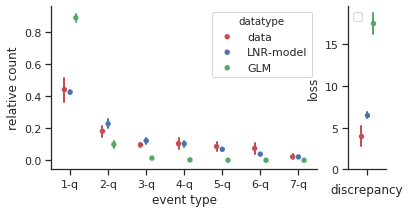

In [59]:

w_scale_one = np.ones(9)

sns.set_style('ticks')

w = w_norm * w_scale


plot_event_loss_histo_comprison_relative(data_short,fit_short, w,   plot_glm=True, glm_data=glm_fit, 
                                         dodge=0.3, relative=True)

filename = 'histo_data_bin_relative.svg'
#plt.savefig(filename, bbox_inches='tight', format='svg')

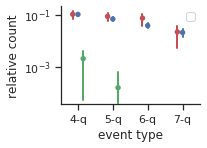

In [60]:
sns.set_style('ticks')

figsize=(2.5,1.8) # (6,3)
lower = 4

df = plot_event_histo_relative_inset(data, fit, 
                          plot_glm=True, 
                          glm_data=glm_fit,
                          dodge=0.3, 
                          relative=True, 
                          logscale=True,
                            lower=lower, 
                            figsize = figsize)

filename = 'histo_data_bin_relative_inset.svg'
plt.savefig(filename, bbox_inches='tight', format='svg')

## raster plot

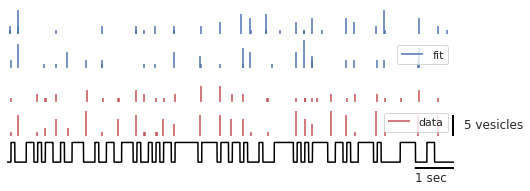

In [61]:

sns.set_context("notebook")
S0 = 5000
S = 6170

t_plot = np.arange(0, S*10-S0*10)/1000

plt.figure(1, figsize=(8,3)) # 10 4

# plot fitted
yscalebar=False
count=0
for i in [1,2]: # [6,2]
    ax=plt.subplot(5,1,count+1)
    if i==0:
        yscalebar=True
    plot_raster1_new(ax,fit[i,S0:S],  color='b',  label='fit', scalebar=yscalebar, scalebarcolor='black')
    yscalebar=False
    count+=1

plt.legend()

# plot data traces
yscalebar=False
count=0
for i in [0,1]: #0,3
    ax=plt.subplot(5,1,count+2+1)
    if count==1:
        yscalebar=True
    plot_raster1_new(ax,data[i,S0:S],  color='r',  label='data', scalebar=yscalebar, scalebarcolor='black')
    count+=1
plt.legend()

# plot stimulus
ax=plt.subplot(5,1,5)
plt.plot(t_plot, light[S0*10:S*10], color='black')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlim(t_plot[0], t_plot[-1])

#sns.despine()
plt.yticks([])
plt.xticks([])
#plt.xlabel('sec')

#scalebar
scalebar = np.ones(len(t_plot)) * (-0.3)
for i in range(len(scalebar)):
    if i>len(scalebar) or i<len(scalebar)-1000: # 1 tpt is 1ms => 1000 = 1sec
        scalebar[i] = np.nan

plt.plot(t_plot, scalebar, linewidth=2, color = 'black' )
plt.text(t_plot[-1]-1,-0.95,'1 sec')


filename = 'raster_fit_binary.svg'
#plt.savefig( filename, dpi=300, format='svg')    


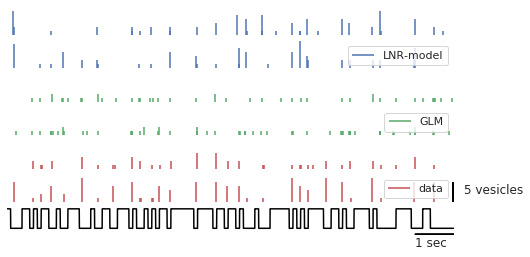

In [62]:
"""
raster including GLM
"""
"""
shorten also light
"""

light_short = light[11*10:]



sns.set_context("notebook")
S0 = 5000
S = 6170

t_plot = np.arange(0, S*10-S0*10)/1000

plt.figure(1, figsize=(8,4.2)) # 8,3 

# plot fitted
yscalebar=False
count=0
for i in [1,2]: # [6,2]
    ax=plt.subplot(7,1,count+1)
    if i==0:
        yscalebar=True
    plot_raster1_new(ax,fit_short[i,S0:S],  color='b',  label='LNR-model', scalebar=yscalebar, scalebarcolor='black')
    yscalebar=False
    count+=1

plt.legend()


# plot GLM fitted
yscalebar=False
count=0
for i in [1,4]: # [6,2]
    ax=plt.subplot(7,1,count+2+1)
    if i==0:
        yscalebar=True
    plot_raster1_new(ax,glm_fit[i,S0:S],  color='g',  label='GLM', scalebar=yscalebar, scalebarcolor='black')
    yscalebar=False
    count+=1

plt.legend()



# plot data traces
yscalebar=False
count=0
for i in [0,1]: #0,3
    ax=plt.subplot(7,1,count+4+1)
    if count==1:
        yscalebar=True
    plot_raster1_new(ax,data_short[i,S0:S],  color='r',  label='data', scalebar=yscalebar, scalebarcolor='black')
    count+=1
plt.legend()

# plot stimulus
ax=plt.subplot(7,1,7)
plt.plot(t_plot, light_short[S0*10:S*10], color='black')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlim(t_plot[0], t_plot[-1])

#sns.despine()
plt.yticks([])
plt.xticks([])
#plt.xlabel('sec')

#scalebar
scalebar = np.ones(len(t_plot)) * (-0.3)
for i in range(len(scalebar)):
    if i>len(scalebar) or i<len(scalebar)-1000: # 1 tpt is 1ms => 1000 = 1sec
        scalebar[i] = np.nan

plt.plot(t_plot, scalebar, linewidth=2, color = 'black' )
plt.text(t_plot[-1]-1,-0.95,'1 sec')


filename = 'raster_fit_binary_with_GLM.svg'
#plt.savefig( filename, dpi=300, format='svg')    
